In [1]:
import locale
locale.setlocale(locale.LC_ALL,'en_US')

import pandas
import collections
import itertools
import numpy as np
import lifelines

from matplotlib import pyplot as plt

import matplotlib_venn
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')

%matplotlib inline

In [2]:
FIG_SIZE = (5, 3)

In [3]:
data = pandas.read_csv('../data/github-cran-150601.csv', index_col=0)

data['Date'] = pandas.to_datetime(data['Date'])
data['Dependencies'] = data['Dependencies'].map(lambda x: [] if pandas.isnull(x) else x.split(' '))

data = data[['Package', 'Version', 'Date', 'InCRAN', 'InGitHub', 'Dependencies']]
alldata = data.copy()

In [4]:
_github = data.query('InGitHub == 1')
_cran = data.query('InCRAN == 1')

_archived = pandas.read_csv('../data/cran-packages-150601.csv')
_archived = _archived.query('archived == False').rename(columns={'package': 'Package'})

_cran = _cran.merge(_archived[['Package']], how='inner', on=['Package'])
data = pandas.concat([_github, _cran])

In [5]:
len(_cran.groupby('Package')), len(_cran)

(6706, 44459)

In [6]:
trivial_pkg = set(('R MASS Matrix base boot class cluster codetools compiler datasets foreign grDevices ' +
        'graphics grid lattice methods mgcv nlme nnet parallel rpart ' +
        'spatial splines stats stats4 survival tcltk tools translations utils').split(' '))

github_pkg = set(data.query('InGitHub == 1').drop_duplicates('Package')['Package'])
cran_pkg = set(data.query('InCRAN == 1').drop_duplicates('Package')['Package'])

In [7]:
cran_required_by_cran = []
cran_required_by_github = []

tmp_df = pandas.DataFrame(index=data.index)
tmp_df['RequireCRAN'] = 0
tmp_df['RequireGitHub'] = 0
tmp_df['RequireUnknown'] = 0

for ix, row in data.iterrows():
    for dep in row['Dependencies']:
        if dep in trivial_pkg:
            pass
        else:
            incran = dep in cran_pkg
            ingithub = dep in github_pkg
            
            if incran:
                tmp_df.loc[ix]['RequireCRAN'] += 1
                if row['InGitHub'] == 1:
                    cran_required_by_github.append(dep)
                elif row['InCRAN'] == 1:
                    cran_required_by_cran.append(dep)

            if ingithub:
                if not incran:
                    tmp_df.loc[ix]['RequireGitHub'] += 1
            
            if not incran and not ingithub:
                tmp_df.loc[ix]['RequireUnknown'] += 1
                
data = data.join(tmp_df)                

cran_required_by_cran = collections.Counter(cran_required_by_cran)
cran_required_by_github = collections.Counter(cran_required_by_github)

## Overview

In [8]:
print len(alldata.query('InCRAN == 1')), 'pairs CRAN package/version'
print len(alldata.query('InCRAN == 1').drop_duplicates('Package')), 'CRAN packages'
print len(data.query('InCRAN == 1').drop_duplicates('Package')), 'unarchived CRAN packages'

print len(alldata.query('InGitHub == 1')), 'pairs GH package/version'
print len(alldata.query('InGitHub == 1').drop_duplicates('Package')), 'GH packages'

49393 pairs CRAN package/version
7871 CRAN packages
6706 unarchived CRAN packages
50368 pairs GH package/version
4512 GH packages


## New created packages on GitHub and CRAN

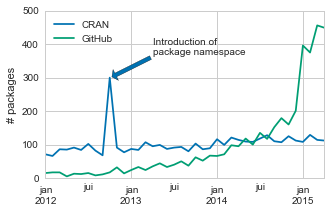

In [9]:
fig, ax = plt.subplots()

time_window = slice('2012', '2015-05-01')

tmp = alldata.query('InCRAN == 1').sort('Date').drop_duplicates(['Package'])[['Date', 'InCRAN']].set_index('Date')
tmp = tmp.rename(columns={'InCRAN': 'CRAN'})
tmp.resample('1M', how='count')[time_window].plot(ax=ax)

tmp = alldata.query('InGitHub == 1').sort('Date').drop_duplicates(['Package'])[['Date', 'InGitHub']].set_index('Date')
tmp = tmp.rename(columns={'InGitHub': 'GitHub'})
tmp.resample('1M', how='count')[time_window].plot(ax=ax)

fig.set_size_inches(FIG_SIZE)
#ax.set_title('Number of new R packages by month')
ax.set_xlabel('')
ax.set_ylabel('# packages')

ax.annotate('Introduction of\npackage namespace', xy=('2012-10-01', 300), xytext=('2013-04', 370), arrowprops=dict(shrink=0.05))

plt.savefig('../figures/pkg_number_by_month.pdf', bbox_inches='tight')

## Packages on GitHub and CRAN

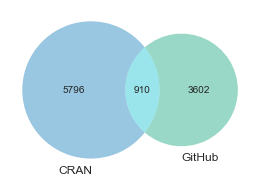

In [10]:
fig, ax = plt.subplots()

matplotlib_venn.venn2((cran_pkg, github_pkg), ('CRAN', 'GitHub'), set_colors=seaborn.color_palette(), ax=ax)

fig.set_size_inches(FIG_SIZE)
#ax.set_title('Number of R packages by source')

plt.savefig('../figures/pkg_venn.pdf', bbox_inches='tight')

## Time needed to be distributed on CRAN

In [11]:
github_date = alldata.query('InGitHub == 1').sort('Date').drop_duplicates('Package').set_index('Package')[['Date', 'InGitHub']]
cran_date = alldata.query('InCRAN == 1').sort('Date').drop_duplicates('Package').set_index('Package')[['Date', 'InCRAN']]

_f = lambda row: pandas.Timestamp('2015-06-01') - row['Date'] if pandas.isnull(row['Date_cran']) else row['Date_cran'] - row['Date']
github_cran_date = github_date.join(cran_date, how='left', rsuffix='_cran')
duration = github_cran_date.apply(_f, axis=1).dt.days
observed = ~pandas.isnull(github_cran_date['Date_cran'])

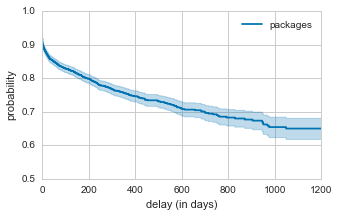

In [12]:
fig, ax = plt.subplots()

kmf = lifelines.KaplanMeierFitter()
kmf.fit(duration, observed, label='packages')
kmf.plot(ax=ax)

fig.set_size_inches(FIG_SIZE)
#ax.set_title('Time needed to distribute a GitHub package on CRAN ')
ax.set_xlabel('delay (in days)')
ax.set_ylabel('probability')
ax.set_xlim(0, 1200)
ax.set_ylim(0.5, 1)

plt.savefig('../figures/joining_cran.pdf', bbox_inches='tight')

In [13]:
github_cran_date['age'] = (pandas.Timestamp('2015-06-01') - github_cran_date['Date']).dt.days

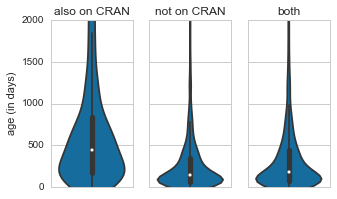

In [15]:
fig, axes = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(FIG_SIZE)
#fig.suptitle('Distribution of the age of GitHub packages', y=1.05)


tmp = github_cran_date.fillna({'InCRAN': 0})

map(lambda x: x[0].set_title(x[1]), zip(axes, ['also on CRAN', 'not on CRAN', 'both']))
seaborn.violinplot(data=tmp.query('InCRAN == 1'), y='age', ax=axes[0])
seaborn.violinplot(data=tmp.query('InCRAN == 0'), y='age', ax=axes[1])
seaborn.violinplot(data=tmp, y='age', ax=axes[2])

axes[0].set_ylim(0, 2000)
axes[0].set_ylabel('age (in days)')
map(lambda x: x.set_ylabel(''), axes[1:])

plt.savefig('../figures/age_github.pdf', bbox_inches='tight')

In [14]:
from scipy.stats import mannwhitneyu

mannwhitneyu(tmp.query('InCRAN == 0')['age'], tmp.query('InCRAN == 1')['age'])

MannwhitneyuResult(statistic=945643.5, pvalue=3.822243315801625e-95)

In [15]:
print tmp.describe()
print tmp.query('InCRAN == 1').describe()
print tmp.query('InCRAN == 0').describe()

       InGitHub       InCRAN          age
count      4512  4512.000000  4512.000000
mean          1     0.208555   352.317154
std           0     0.406321   454.538486
min           1     0.000000     0.000000
25%           1     0.000000    78.000000
50%           1     0.000000   179.000000
75%           1     0.000000   440.250000
max           1     1.000000  3484.000000
       InGitHub  InCRAN          age
count       941     941   941.000000
mean          1       1   646.484591
std           0       0   644.291926
min           1       1     3.000000
25%           1       1   172.000000
50%           1       1   448.000000
75%           1       1   842.000000
max           1       1  3243.000000
       InGitHub  InCRAN          age
count      3571    3571  3571.000000
mean          1       0   274.800616
std           0       0   350.631458
min           1       0     0.000000
25%           1       0    69.000000
50%           1       0   143.000000
75%           1       0   353.

In [16]:
median = github_cran_date.fillna(0).query('InCRAN == 1')['age'].median()
print 'Median age for distibuted packages:', median

print github_cran_date.fillna(0).query('InCRAN == 0 and age >= %f' % median).describe()
print github_cran_date.fillna(0).query('age >= %f' % median).describe()

Median age for distibuted packages: 448.0
       InGitHub  InCRAN          age
count       636     636   636.000000
mean          1       0   859.393082
std           0       0   461.373434
min           1       0   448.000000
25%           1       0   541.000000
50%           1       0   709.000000
75%           1       0   995.250000
max           1       0  3484.000000
       InGitHub       InCRAN          age
count      1107  1107.000000  1107.000000
mean          1     0.425474   960.178862
std           0     0.494638   556.484053
min           1     0.000000   448.000000
25%           1     0.000000   566.000000
50%           1     0.000000   757.000000
75%           1     1.000000  1173.000000
max           1     1.000000  3484.000000


## Sources needed to install packages

In [17]:
targets = ['RequireCRAN', 'RequireGitHub', 'RequireUnknown', 'RequireGitHub_or_Unknown']

data['NRequired'] = data['RequireCRAN'] + data['RequireGitHub'] + data['RequireUnknown']
data['RequireGitHub_or_Unknown'] = data['RequireGitHub'] + data['RequireUnknown']

tmp = collections.OrderedDict()
tmp['CRAN'] = data.query('InCRAN == 1').sort('Date').drop_duplicates('Package', take_last=True)
tmp['GitHub'] = data.query('InGitHub == 1').sort('Date').drop_duplicates('Package', take_last=True)
tmp['GitHub excl.'] = tmp['GitHub'].merge(tmp['CRAN'], how='left', on='Package', suffixes=('', '_cran'))[['Package', 'NRequired', 'InCRAN_cran'] + targets].query('InCRAN_cran != 1')

required_sources = pandas.DataFrame(index=tmp.keys(), columns=targets + [t + '_p' for t in targets])
dependencies_sources = pandas.DataFrame(index=required_sources.index, columns=required_sources.columns)

for source, df in tmp.iteritems():
    n1 = len(df)
    for target in targets:
        n2 = len(df.query(target+' > 0'))
        required_sources.loc[source][target] = n2
        required_sources.loc[source][target + '_p'] = 1.0 * n2 / n1
        
        dependencies_sources.loc[source][target] = df[target].sum()
        dependencies_sources.loc[source][target + '_p'] = 1.0 * df[target].sum() / df['NRequired'].sum()

,RequireCRAN,RequireGitHub,RequireUnknown,RequireGitHub_or_Unknown,RequireCRAN_p,RequireGitHub_p,RequireUnknown_p,RequireGitHub_or_Unknown_p
CRAN,4122,52,121,141,0.6146734,0.00775425,0.01804354,0.02102595
GitHub,3187,388,534,767,0.7063387,0.08599291,0.1183511,0.1699911
GitHub excl.,2498,382,519,748,0.6935036,0.1060522,0.1440866,0.2076624


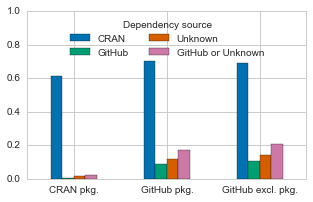

In [18]:
fig, ax = plt.subplots()


_ = required_sources[[t+'_p' for t in targets]].rename(columns={t+'_p': t[7:].replace('_', ' ') for t in targets})
_.plot(kind='bar', stacked=False, ax=ax)

fig.set_size_inches(FIG_SIZE)
#ax.set_title('Proportion of packages with a dependency in given source')
ax.legend(title='Dependency source', loc='upper center', ncol=2)
ax.set_xticklabels([s + ' pkg.' for s in required_sources.index], rotation=0)
ax.set_ylim(top=1)

#ax.annotate('Satisfied by\nBioConductor', xy=(0.2, 0.05), xytext=(0.25, 0.25), arrowprops=dict(shrink=0.05))

plt.savefig('../figures/deps-bypkg.pdf', bbox_inches='tight')

required_sources

,RequireCRAN,RequireGitHub,RequireUnknown,RequireGitHub_or_Unknown,RequireCRAN_p,RequireGitHub_p,RequireUnknown_p,RequireGitHub_or_Unknown_p
CRAN,11265,55,177,232,0.9798208,0.004783857,0.01539532,0.02017918
GitHub,11559,546,1441,1987,0.8533146,0.0403071,0.1063783,0.1466854
GitHub excl.,8935,540,1424,1964,0.8198,0.04954583,0.1306542,0.1802


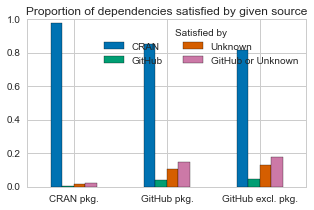

In [19]:
fig, ax = plt.subplots()


_ = dependencies_sources[[t+'_p' for t in targets]].rename(columns={t+'_p': t[7:].replace('_', ' ') for t in targets})
_.plot(kind='bar', stacked=False, ax=ax)

fig.set_size_inches(FIG_SIZE)
ax.set_title('Proportion of dependencies satisfied by given source')
ax.legend(title='Satisfied by', loc='best', ncol=2)
ax.set_xticklabels([s + ' pkg.' for s in dependencies_sources.index], rotation=0)

#ax.annotate('Satisfied by\nBioConductor', xy=(0.2, 0.05), xytext=(0.25, 0.25), arrowprops=dict(shrink=0.05))

plt.savefig('../figures/deps-bydeps.pdf', bbox_inches='tight')

dependencies_sources

In [20]:
sources = ['CRAN', 'GitHub', 'Unknown']
graph = {source_a: {source_b: {'pkg': None, 'dep': None} for source_b in sources} for source_a in sources[:2]}

for source_a in sources[:2]: 
    for source_b in sources:
        A, B = source_a, 'Require%s' % source_b
        graph[source_a][source_b]['pkg'] = required_sources.loc[A][B]
        graph[source_a][source_b]['pkg_p'] = required_sources.loc[A][B+'_p']
        graph[source_a][source_b]['dep'] = dependencies_sources.loc[A][B]
        graph[source_a][source_b]['dep_p'] = dependencies_sources.loc[A][B+'_p']
        
graph

{'CRAN': {'CRAN': {'dep': 11265,
   'dep_p': 0.9798208228233453,
   'pkg': 4122,
   'pkg_p': 0.6146734267819863},
  'GitHub': {'dep': 55,
   'dep_p': 0.004783856658258676,
   'pkg': 52,
   'pkg_p': 0.007754249925439905},
  'Unknown': {'dep': 177,
   'dep_p': 0.015395320518396103,
   'pkg': 121,
   'pkg_p': 0.01804354309573516}},
 'GitHub': {'CRAN': {'dep': 11559,
   'dep_p': 0.8533146316255721,
   'pkg': 3187,
   'pkg_p': 0.7063386524822695},
  'GitHub': {'dep': 546,
   'dep_p': 0.04030710172744722,
   'pkg': 388,
   'pkg_p': 0.08599290780141844},
  'Unknown': {'dep': 1441,
   'dep_p': 0.10637826664698066,
   'pkg': 534,
   'pkg_p': 0.11835106382978723}}}

## Required packages

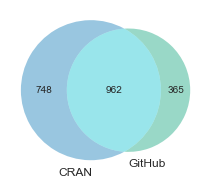

In [21]:
fig, ax = plt.subplots()

matplotlib_venn.venn2((set(cran_required_by_cran), set(cran_required_by_github)), ('CRAN', 'GitHub'), set_colors=seaborn.color_palette(), ax=ax)

fig.set_size_inches(FIG_SIZE)
#ax.set_title('Required CRAN packages by source')

plt.savefig('../figures/required.pdf', bbox_inches='tight')

In [22]:
"""
print 'CRAN packages required by CRAN packages'
print ','.join(cran_required_by_cran)
print
print 'CRAN packages required by GitHub packages'
print ','.join(cran_required_by_github)
"""

"\nprint 'CRAN packages required by CRAN packages'\nprint ','.join(cran_required_by_cran)\nprint\nprint 'CRAN packages required by GitHub packages'\nprint ','.join(cran_required_by_github)\n"

In [23]:
data_travis = pandas.read_csv('../data/r-travis.csv')[['owner', 'repository']].drop_duplicates()
github_repo = pandas.read_csv('../data/github-raw-150601.csv')[['Owner','Repository', 'Package']].drop_duplicates()

data_travis = data_travis.rename(columns={'owner': 'Owner', 'repository': 'Repository'})

tmp = data_travis.merge(github_repo, on=['Owner', 'Repository'])
print len(data.query('InGitHub == 1')[['Package']].merge(tmp, on='Package').drop_duplicates()),'with Travis'

1064 with Travis


### Update frequency

In [24]:
data_required = data.query('InCRAN > 0').copy()[['Package', 'Version', 'Date']]
data_required['RequiredByCRAN'] = data_required['Package'].isin(cran_required_by_cran)
data_required['RequiredByGitHub'] = data_required['Package'].isin(cran_required_by_github)

label = lambda row: 'Both' if row['RequiredByCRAN'] and row['RequiredByGitHub'] else ('CRAN only' if row['RequiredByCRAN'] else ('GitHub only' if row['RequiredByGitHub'] else 'None'))
data_required['RequiredBy'] = data_required.apply(label, axis=1)

def package_updates(dataframe, right_censor):
    """
    Return a DataFrame ix -> {duration:x, observed: y}. 
    Given dataframe must concern only ONE package.
    """
    censor_date = pandas.Timestamp(right_censor)
    
    shifted = dataframe.sort('Date')['Date'].shift(-1)
    dataframe['Observed'] = pandas.notnull(shifted)
    dataframe['Duration'] = shifted.where(dataframe['Observed'], censor_date) - dataframe['Date']
        
    return dataframe

In [25]:
window = slice('2014-12-01 00:00:00', '2015-06-01 00:00:00')

data_updates = data_required.set_index('Date')[window].reset_index()
data_updates = data_updates.groupby('Package').apply(package_updates, right_censor=window.stop)
print len(data_updates)

3740


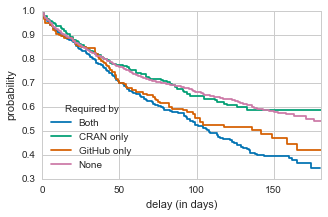

In [26]:
fig, ax = plt.subplots()

data_kmf = pandas.DataFrame()

for name, group in data_updates.groupby('RequiredBy'):    
    kmf = lifelines.KaplanMeierFitter()
    kmf.fit(group['Duration'].dt.days, group['Observed'], label=name)
    data_kmf = pandas.concat([data_kmf, kmf.survival_function_], axis=1)
    kmf.plot(ax=ax, ci_show=False)

fig.set_size_inches(FIG_SIZE)
ax.set_xlabel('delay (in days)')
ax.set_ylabel('probability')

#ax.set_title('CRAN package is not updated')
ax.legend(title='Required by', loc='lower left')

plt.savefig('../figures/updated_packages.pdf', bbox_inches='tight')

In [50]:
data_kmf['GH_at_least'] = data_kmf[['Both', 'GitHub']].max(axis=1)
data_kmf['Other'] = data_kmf[['CRAN', 'None']].min(axis=1)
data_kmf.query('GH_at_least <= Other')[25:75]

,Both,CRAN,GitHub,None,GH_at_least,Other
timeline,,,,,,
25,0.837746,0.861536,0.851502,0.855942,0.851502,0.855942
26,0.836208,0.858157,0.851502,0.853081,0.851502,0.853081
29,0.820554,0.841116,NaN,0.838029,0.820554,0.838029
36,0.779918,0.819468,0.807639,0.813176,0.807639,0.813176
37,0.779918,0.815709,0.802745,0.811619,0.802745,0.811619
38,0.774908,0.808191,0.792955,0.809016,0.792955,0.808191
39,0.768213,0.804397,0.788060,0.805888,0.788060,0.804397
40,0.764829,0.800584,0.782976,0.802736,0.782976,0.800584
41,0.756216,NaN,0.777791,0.799027,0.777791,0.799027


In [52]:
from lifelines.statistics import logrank_test

groups = data_updates.groupby('RequiredBy')

print logrank_test(groups.get_group('GitHub')['Duration'].dt.days, 
             groups.get_group('CRAN')['Duration'].dt.days, 
             groups.get_group('GitHub')['Observed'], 
             groups.get_group('CRAN')['Observed'], 
             alpha=0.95)

print logrank_test(groups.get_group('Both')['Duration'].dt.days, 
             groups.get_group('CRAN')['Duration'].dt.days, 
             groups.get_group('Both')['Observed'], 
             groups.get_group('CRAN')['Observed'], 
             alpha=0.95)

<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.03034 |              4.690 |      Reject Null    |        True       
>
<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.00009 |             15.362 |      Reject Null    |        True       
>


## Packages upgrades impact

1. Look for CRAN packages that are required by other CRAN packages. 
2. Get all the upgrades of the packages from (1). 
3. Look if dependant packages was in ERROR at the same time. 

In [42]:
import gzip
data_errors = pandas.read_csv(gzip.GzipFile('../data/checks-history.csv.gz'))[['date', 'package', 'version', 'status']]

In [43]:
window = slice(pandas.Timestamp('2014-12-01 12:45:40'), pandas.Timestamp('2015-06-01'))

data_errors['date'] = pandas.to_datetime(data_errors['date'])
data_errors = data_errors[window.start <= data_errors['date']][data_errors['date'] <= window.stop]

/usr/lib64/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [44]:
data_errors['date'] = data_errors['date'].map(lambda x: x.replace(hour=0, minute=0, second=0))

In [45]:
# (1)
required_by = {}

for ix, row in data.query('InCRAN == 1').iterrows():
    for dep in row['Dependencies']: 
        if dep in cran_pkg:
            required_by.setdefault(dep, set()).add(row['Package'])

In [46]:
# (2)
data_errors_required = data_errors[data_errors['package'].isin(required_by.keys())]
# Filter packages that have no update
data_errors_required_upgrades = data_errors_required.sort('date').groupby(['package', 'version']).first()
data_errors_required_upgrades = data_errors_required_upgrades.reset_index().groupby('package').filter(lambda d: len(d) > 1)
# Get package-date for each (non-first) upgrade
data_errors_required_upgrades = data_errors_required_upgrades.drop(data_errors_required_upgrades.reset_index().groupby('package').first()['index'])

In [47]:
print 'Number of required packages that had an upgrade'
print len(data_errors_required_upgrades.groupby('package'))
print 'Number of upgrades in required packages'
print len(data_errors_required_upgrades)

Number of required packages that had an upgrade
643
Number of upgrades in required packages
1029


In [48]:
data_errors_errors = data_errors.query('status == "ERROR"')
upgrade_errors = []

for ix, row in data_errors_required_upgrades.iterrows():
    for depend in required_by.get(row['package'], []):
        # look if depend at date row['date'] is in ERROR
        df = data_errors_errors.query('package == "{pkg}" and date == "{date}"'.format(pkg=depend, date=row['date']))
        if len(df) > 0: 
            upgrade_errors.append((depend, row['package'], row['date']))

In [49]:
data_upgrade_errors = pandas.DataFrame.from_records(upgrade_errors, columns=['depend', 'package', 'date'])

print 'Number of upgrade errors in dependant package'
print len(data_upgrade_errors)
print 'Number of packages impacted'
print len(data_upgrade_errors.groupby('depend'))

print 'Number of required packages that lead to an error'
print len(data_upgrade_errors.groupby('package'))

print 'Number of distinct upgrades that broke a dependant package'
print len(data_upgrade_errors.groupby(['package', 'date']))

Number of upgrade errors in dependant package
84
Number of packages impacted
60
Number of required packages that lead to an error
46
Number of distinct upgrades that broke a dependant package
59


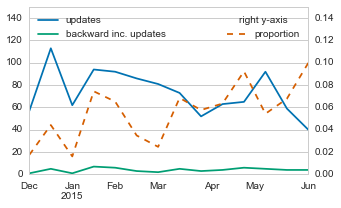

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches(FIG_SIZE)

freq = '2W'

data_errors_summary = pandas.concat({'upgrades': data_errors_required_upgrades.set_index('date').resample(freq, how='count')['package'],
               'errors': data_upgrade_errors.set_index('date').resample(freq, how='count')['package'],
               'incchanges': data_upgrade_errors.groupby([pandas.Grouper(freq=freq, key='date'), 'package']).count()[[]].reset_index().groupby('date').count(),
               'impact': data_upgrade_errors.groupby(pandas.Grouper(freq=freq, key='date'))['depend'].nunique()},axis=1)


ax = data_errors_summary[['upgrades', 'incchanges']].plot(ax=ax)
ax2 = (data_errors_summary['incchanges'] / data_errors_summary['upgrades']).plot(ax=ax, secondary_y=True, style='--')


ax.grid(True, axis='y')
ax.legend(['updates', 'backward inc. updates'], loc='upper left')
ax.set_xlabel('')
ax.set_ylim(0, 150)

ax2.set_ylim(0, 0.15)
ax2.grid()
ax2.legend(['proportion'], title='right y-axis', loc='upper right')

plt.savefig('../figures/upgrade_impact.pdf', bbox_inches='tight')

In [51]:
(data_errors_summary['incchanges'] / data_errors_summary['upgrades']).mean()

package    0.055808
dtype: float64